In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn import naive_bayes #import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier # simulate the behavior of logistic regression using SGDClassifier(loss='log')
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,balanced_accuracy_score,average_precision_score, classification_report

from sklearn.utils import shuffle
from collections import Counter

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
train_df = pd.read_csv('cfpb_train.csv')
test_df = pd.read_csv('cfpb_test.csv')
dev_df = pd.read_csv('cfpb_dev.csv')

train_df['Consumer complaint narrative'] = train_df['Consumer complaint narrative'].fillna('').astype(str)
test_df['Consumer complaint narrative'] = test_df['Consumer complaint narrative'].fillna('').astype(str)
dev_df['Consumer complaint narrative'] = dev_df['Consumer complaint narrative'].fillna('').astype(str)

train_df['debt_collection'] = (train_df['Product'] == 'Debt collection').astype(int)
test_df['debt_collection'] = (test_df['Product'] == 'Debt collection').astype(int)
dev_df['debt_collection'] = (dev_df['Product'] == 'Debt collection').astype(int)

train_df_sample = train_df.sample(200000)

C:\Users\JYM\AppData\Local\Temp/ipykernel_15076/2992091573.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('cfpb_train.csv')
C:\Users\JYM\AppData\Local\Temp/ipykernel_15076/2992091573.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dev_df = pd.read_csv('cfpb_dev.csv')


In [4]:
# Load the trained vectorizer
with open('tfidf_vectorizer_train_split_33k.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)
len(loaded_vectorizer.get_feature_names_out())

30288

In [5]:
%%time
# Vectorize the text data with pre-tuned vectorizer
X_train = loaded_vectorizer.transform(train_df['Consumer complaint narrative'])
y_train = train_df['debt_collection']

X_train_sample = loaded_vectorizer.transform(train_df_sample['Consumer complaint narrative'])
y_train_sample = train_df_sample['debt_collection']

X_dev = loaded_vectorizer.transform(dev_df['Consumer complaint narrative'])
y_dev = dev_df['debt_collection']

X_test = loaded_vectorizer.transform(test_df['Consumer complaint narrative'])
y_test = test_df['debt_collection']

Wall time: 4min 29s


In [6]:
%%time
selector = SelectKBest(chi2, k=30000)
X_train = selector.fit_transform(X_train, y_train)
X_train_sample = selector.transform(X_train_sample)
X_dev = selector.transform(X_dev)
X_test = selector.transform(X_test)

Wall time: 596 ms


In [7]:
%%time
# some balancing
# from imblearn.over_sampling import SMOTE 
# sm = SMOTE(random_state=42)
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
# # Shuffle your data
# X_train_res, y_train_res = shuffle(X_train_res, y_train_res)
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_train_res, y_train_res = oversample.fit_resample(X_train_sample, y_train_sample)

Wall time: 92 ms


### Descision Tree

In [8]:
%%time
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

# Initialize a LogisticRegression model, ‘log_loss’ gives logistic regression, a probabilistic classifier.
dtree = DecisionTreeClassifier(max_depth=20)

dtree.fit(X_train_res, y_train_res)

Wall time: 36.4 s


DecisionTreeClassifier(max_depth=20)

Train
accuracy_score 0.855085
balanced_accuracy_score 0.7684836743221956
average_precision_score 0.4337304190637864
              precision    recall  f1-score   support

           0       0.92      0.90      0.91    164717
           1       0.58      0.63      0.61     35283

    accuracy                           0.86    200000
   macro avg       0.75      0.77      0.76    200000
weighted avg       0.86      0.86      0.86    200000

Prediction [(0, 161514), (1, 38486)]
Ground Truth [(0, 164717), (1, 35283)]


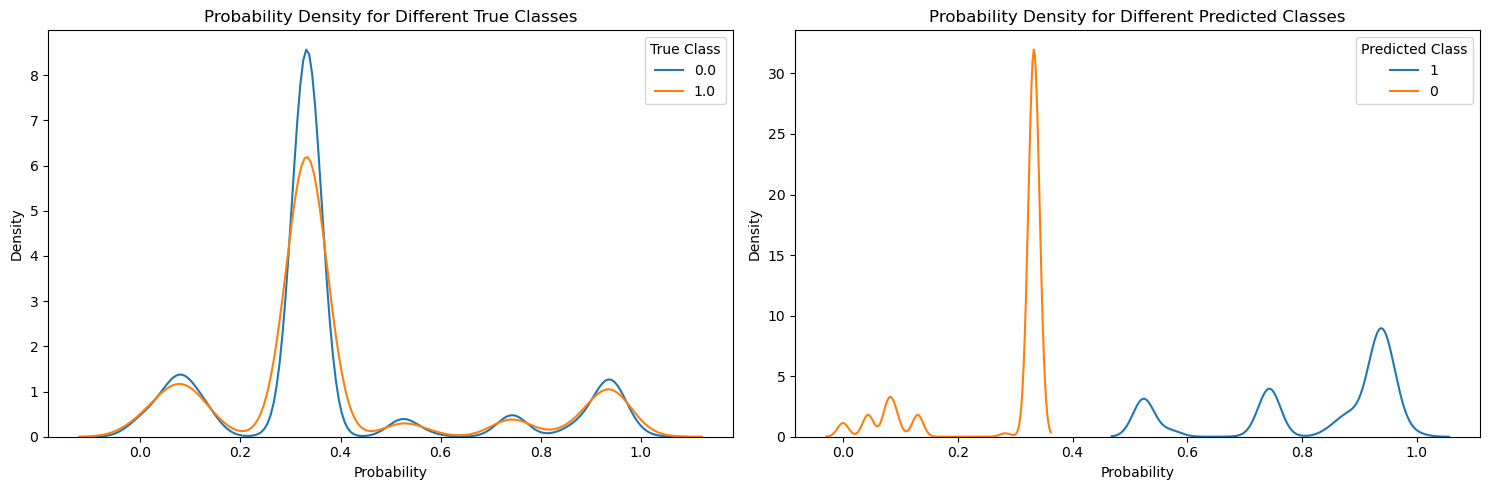

In [9]:
# get the results
y_pred = dtree.predict(X_train_sample.toarray())
y_pred_proba = dtree.predict_proba(X_train_sample.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train_sample, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_sample, y_pred))
print("average_precision_score",average_precision_score(y_train_sample, y_pred))
print(classification_report(y_train_sample, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_train_sample)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_train_sample

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()

Train
accuracy_score 0.8461259079903147
balanced_accuracy_score 0.7540871271866247
average_precision_score 0.4102932461617942
              precision    recall  f1-score   support

           0       0.92      0.90      0.91    136036
           1       0.56      0.61      0.58     29164

    accuracy                           0.85    165200
   macro avg       0.74      0.75      0.74    165200
weighted avg       0.85      0.85      0.85    165200

Prediction [(0, 133258), (1, 31942)]
Ground Truth [(0, 136036), (1, 29164)]


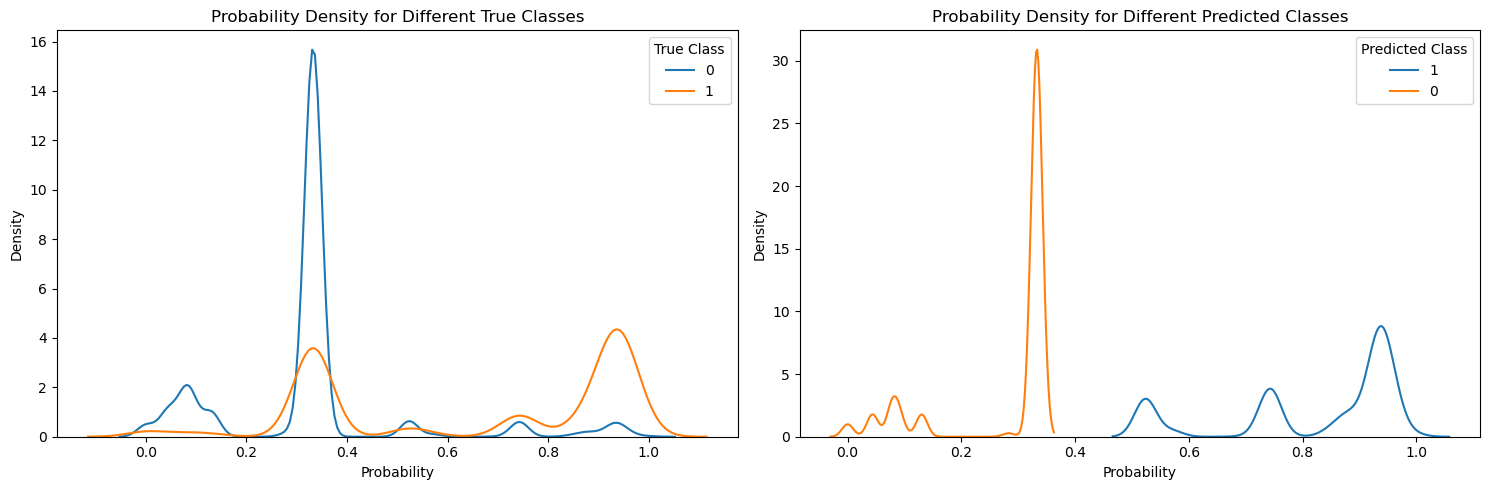

In [10]:
# get the results
y_pred = dtree.predict(X_dev.toarray())
y_pred_proba = dtree.predict_proba(X_dev.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_dev

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()

### Random Forest

In [11]:
%%time
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)
rfc = RandomForestClassifier(max_depth=20, random_state=42, n_estimators =200)
rfc.fit(X_train_res, y_train_res)

Wall time: 1min 19s


RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

Train
accuracy_score 0.892425
balanced_accuracy_score 0.8335907107700786
average_precision_score 0.549049315015372
              precision    recall  f1-score   support

           0       0.94      0.92      0.93    164717
           1       0.68      0.74      0.71     35283

    accuracy                           0.89    200000
   macro avg       0.81      0.83      0.82    200000
weighted avg       0.90      0.89      0.89    200000

Prediction [(0, 161360), (1, 38640)]
Ground Truth [(0, 164717), (1, 35283)]


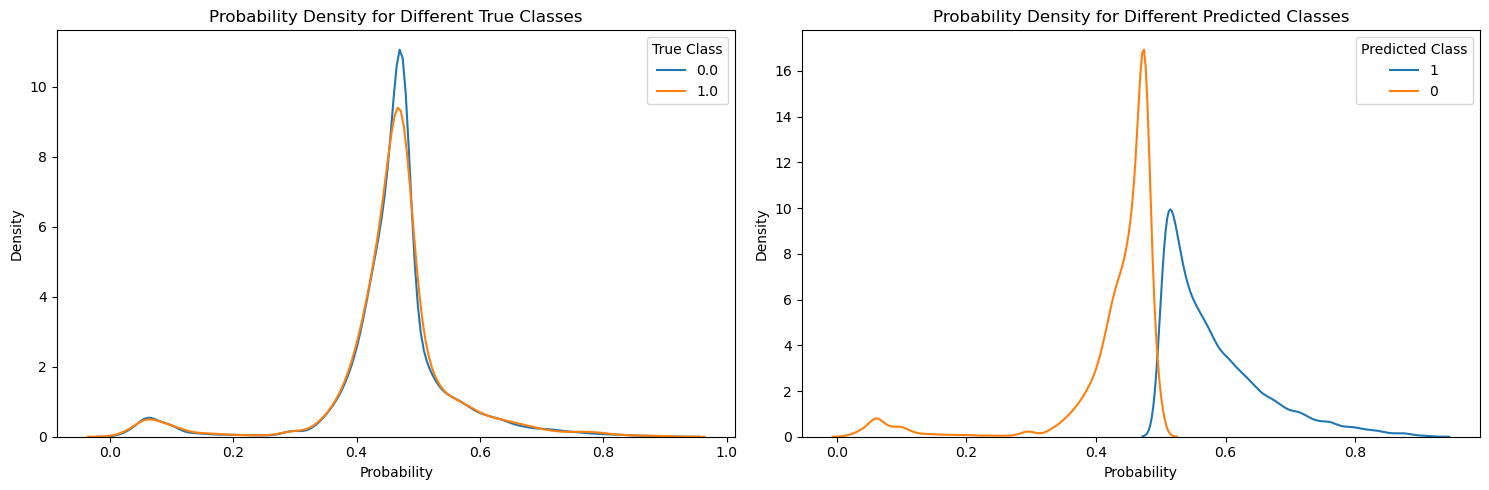

In [12]:
# get the results
y_pred = rfc.predict(X_train_sample.toarray())
y_pred_proba = rfc.predict_proba(X_train_sample.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train_sample, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_sample, y_pred))
print("average_precision_score",average_precision_score(y_train_sample, y_pred))
print(classification_report(y_train_sample, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_train_sample)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_train_sample

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()

Train
accuracy_score 0.8861440677966101
balanced_accuracy_score 0.8241128492982561
average_precision_score 0.5294724369689534
              precision    recall  f1-score   support

           0       0.94      0.92      0.93    136036
           1       0.66      0.73      0.69     29164

    accuracy                           0.89    165200
   macro avg       0.80      0.82      0.81    165200
weighted avg       0.89      0.89      0.89    165200

Prediction [(0, 133079), (1, 32121)]
Ground Truth [(0, 136036), (1, 29164)]


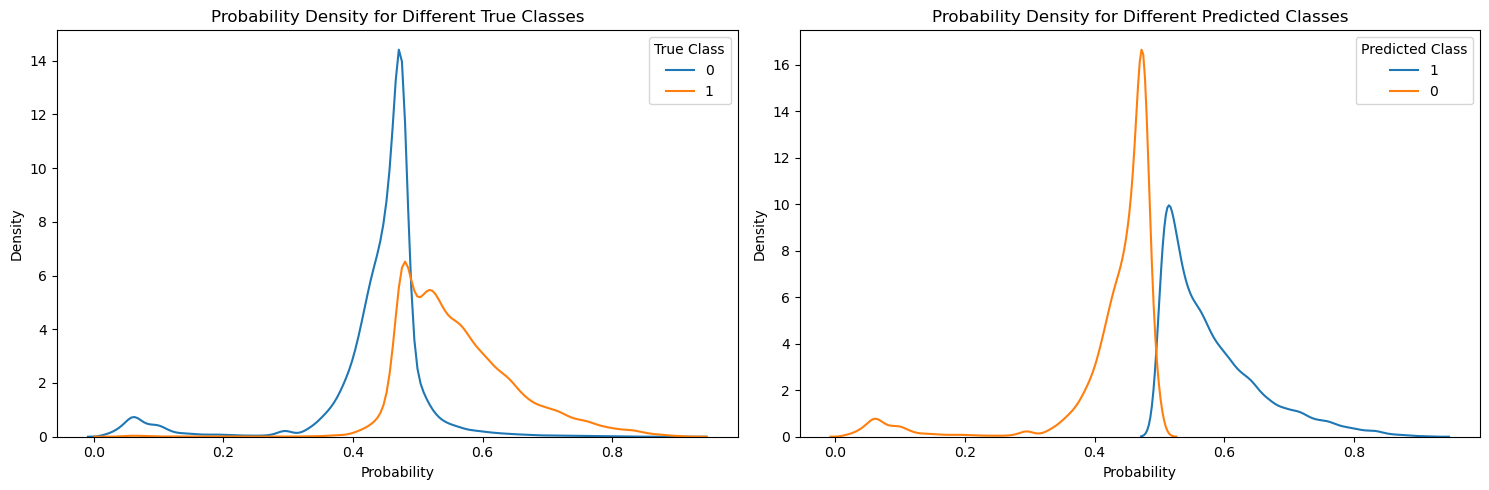

In [15]:
# get the results
y_pred = rfc.predict(X_dev.toarray())
y_pred_proba = rfc.predict_proba(X_dev.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_dev

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()